# Ejercicio Regression Tree
Son datos de temperaturas tomados de la ciudad de Seattle. El objetivo es intentar predecir lo mejor posible la máxima temperatura (columna `actual`) que alcanzaremos al día siguiente. Para ello contaremos con temperaturas de los dos días anteriores, históricos de máximas temperaturas y un amigo bastante chapas que te da su predicción del tiempo cada día.

**Resumen de datos**:
* year: año de las muestras
* month: número del mes del año para la medición
* day: día del año de la medición
* week: día de la semana como carácter
* temp_2: máxima temperatura en los dos días anteriores
* temp_1: máxima temperatura el día anterior
* average: promedio histórico
* actual: temperatura máxima recogida
* friend: predicción de un amigo, 20 por encima y debajo de la temperatura promedio (no es muy buen amigo)


### 1. Importa el csv "temps.csv"

In [49]:
import pandas as pd

df = pd.read_csv("data/temps.csv")
df

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41
...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42


In [50]:
df.drop(columns=["forecast_noaa", "forecast_acc", "forecast_under"], inplace=True)

### 2. Realiza un análisis exploratorio

In [51]:
# Fíjate en si hay variables faltantes, datos constantes, días informados como texto, si podemos agrupar datos por estación...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     348 non-null    int64  
 1   month    348 non-null    int64  
 2   day      348 non-null    int64  
 3   week     348 non-null    object 
 4   temp_2   348 non-null    int64  
 5   temp_1   348 non-null    int64  
 6   average  348 non-null    float64
 7   actual   348 non-null    int64  
 8   friend   348 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 24.6+ KB


In [52]:
df.describe(include='all') #Estadísticas descriptivas

,year,month,day,week,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348,348.000000,348.000000,348.000000,348.000000,348.000000
unique,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Tues,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,52,NaN,NaN,NaN,NaN,NaN
mean,2016.0,6.477011,15.514368,NaN,62.652299,62.701149,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,NaN,12.165398,12.120542,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,NaN,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,NaN,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,NaN,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,NaN,71.000000,71.000000,69.025000,71.000000,71.000000


In [53]:
df.isnull().sum() #Verificar si hay datos faltantes

year       0
month      0
day        0
week       0
temp_2     0
temp_1     0
average    0
actual     0
friend     0
dtype: int64

In [54]:
df.nunique() #Verificar si hay datos constantes

year         1
month       12
day         31
week         7
temp_2      56
temp_1      56
average    243
actual      55
friend      66
dtype: int64

In [55]:
# Verificar el formato de la columna de fechas (si existe)
if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce') # Convertir a formato datetime
    date_conversion_issues = df['fecha'].isnull().sum()
    date_conversion_issues

In [56]:
# Función para determinar la estación del año
def determinar_estacion(fecha):
    if fecha.month == 12 and fecha.day >= 21 or fecha.month in [1, 2] or fecha.month == 3 and fecha.day <= 20:
        return 'Invierno'
    elif fecha.month == 3 and fecha.day >= 21 or fecha.month in [4, 5] or fecha.month == 6 and fecha.day <= 20:
        return 'Primavera'
    elif fecha.month == 6 and fecha.day >= 21 or fecha.month in [7, 8] or fecha.month == 9 and fecha.day <= 22:
        return 'Verano'
    elif fecha.month == 9 and fecha.day >= 23 or fecha.month in [10, 11] or fecha.month == 12 and fecha.day <= 20:
        return 'Otoño'

# Aplicar la función para agregar la columna de estación
if 'fecha' in df.columns:
    df['estacion'] = df['fecha'].apply(determinar_estacion)

# Mostrar las primeras filas para verificar
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


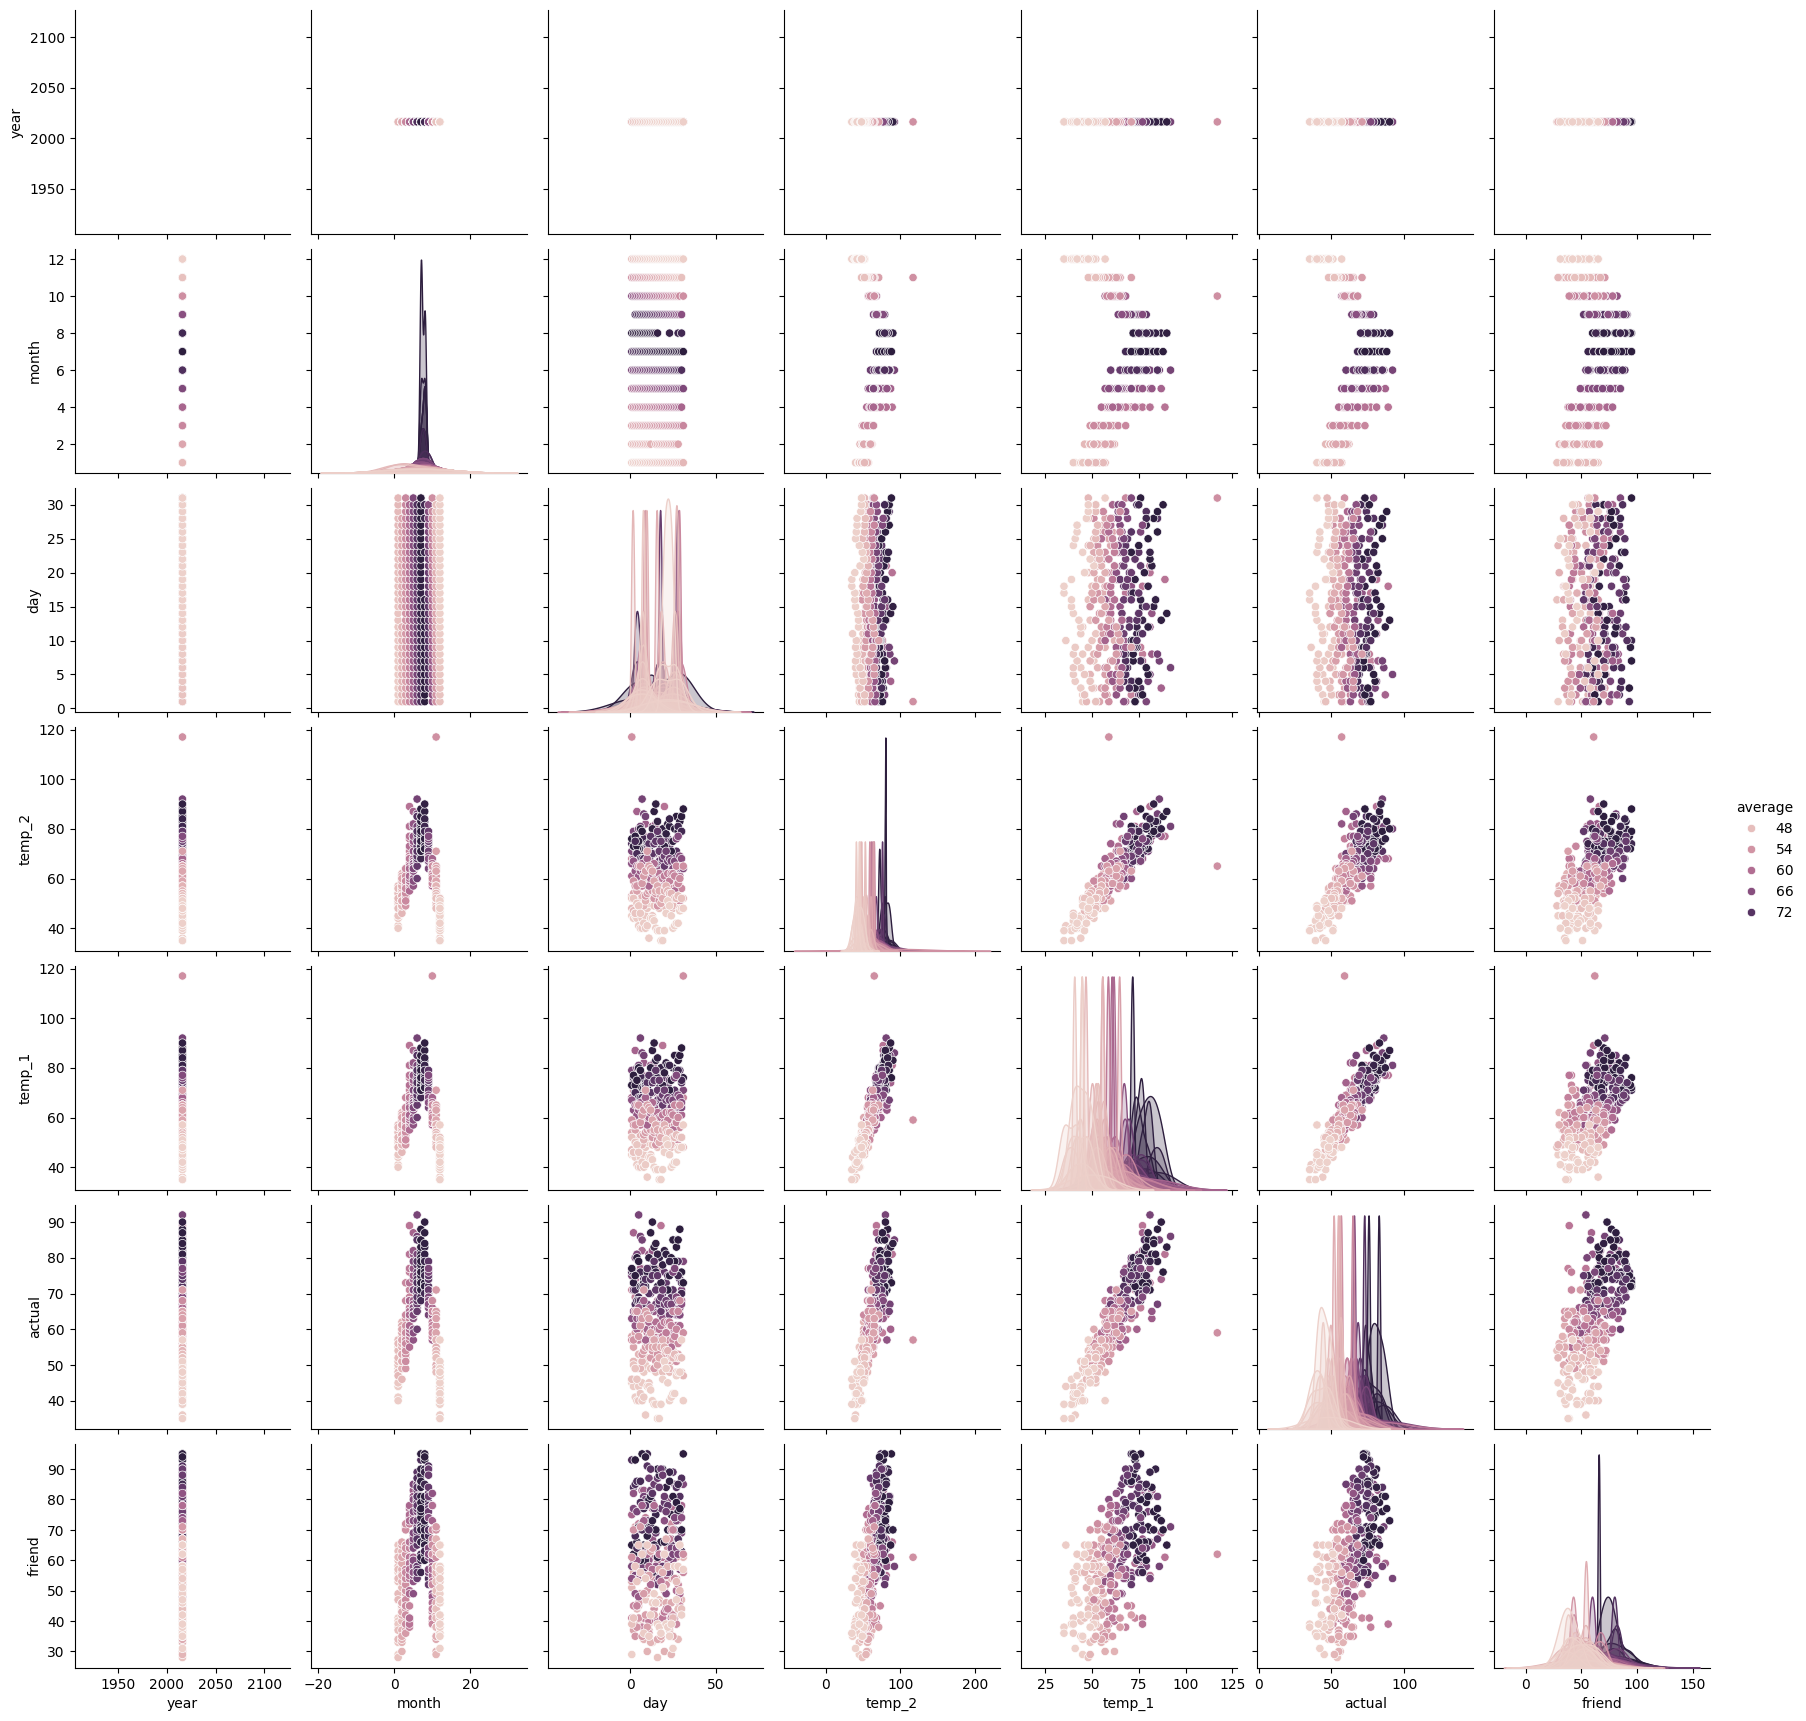

In [57]:
import seaborn as sns

sns.pairplot(df, hue="average")

### 3. Realiza la ingeniería de características

Necesitamos que todos los datos sean numéricos.

In [58]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['week_encoded'] = encoder.fit_transform(df['week'])

In [45]:
df

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_encoded
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29,0
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61,2
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56,3
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53,1
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47,5
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58,6
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65,4
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42,0


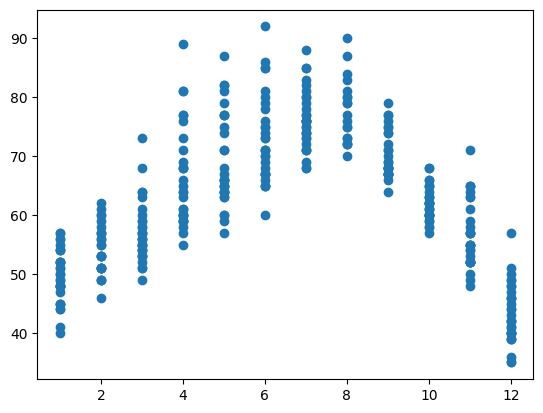

In [35]:
import matplotlib.pyplot as plt

plt.scatter(df['month'], df['actual']);

### 4. Divide en datos de entrenamiento (train) y evaluación (test)

In [59]:
from sklearn.model_selection import train_test_split

# Dividir en conjuntos de entrenamiento y evaluación
x_train, y_test = train_test_split(df, test_size=0.2, random_state=42)

# Mostrar los DataFrames de entrenamiento y evaluación
print("Datos de entrenamiento:")
print(x_train)
print("\nDatos de evaluación:")
print(y_test)

Datos de entrenamiento:
     year  month  day   week  temp_2  temp_1  average  actual  friend  \
177  2016      6   29    Wed      85      79     72.6      74      81   
78   2016      3   22   Tues      55      56     54.6      57      64   
90   2016      4    3    Sun      71      63     56.3      69      64   
16   2016      1   17    Sun      48      54     47.4      50      47   
66   2016      3   10  Thurs      54      55     52.8      56      50   
..    ...    ...  ...    ...     ...     ...      ...     ...     ...   
188  2016      7   10    Sun      74      71     75.1      74      95   
71   2016      3   15   Tues      54      49     53.6      51      70   
106  2016      4   19   Tues      77      89     59.0      81      61   
270  2016     10   14    Fri      66      60     60.2      60      78   
102  2016      4   15    Fri      59      59     58.3      60      40   

     week_encoded  
177             6  
78              5  
90              3  
16              3  

### 5. Entrena el modelo

Juega con los parámetros para ver qué ajuste obtienes.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(x_train, y_train)

In [ ]:
model.score(x_train, y_train)

In [ ]:
model.score(x_test, y_test)

In [ ]:
model.get_depth()

### 6. Evaluación de tu modelo

Calcula las métricas vistas para variable continua (MAE, MAPE, MSE, RMSE)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# ...

### 7. Representa el árbol de decisión

In [58]:
from sklearn.tree import plot_tree

# ...

### 8. Utiliza un grid search con cross validation para hiperparametrizar tu modelo

In [124]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor()

parameters = {
    "max_depth" : [ 2,4,6,8,10,12 ],
    "min_samples_leaf": [ 4,6,8,10,12,14,16 ],
}

dtr_gs = GridSearchCV(model, parameters, cv=5, scoring="neg_mean_absolute_error")
dtr_gs.fit(X_train, y_train)

In [ ]:
# Presenta los mejores parámetros encontrados y su puntuación (deberás inspeccionar la instancia)
dtr_gs.best_params_

In [ ]:
# Obtén el mejor estimador de la instancia
best_model = dtr_gs.best_estimator_

In [ ]:
best_model.score(x_train, y_train)

In [ ]:
best_model.score(x_test, y_test)

### 9. Obten el `feature_importances`

In [ ]:
coeff_df =pd.DataFrame(best_model.feature_importances_,
                       X.columns,
                       columns=["Importance"])


### 10. Construye un nuevo modelo `DecisionTreeClassifier` 

Queremos un modelo que clasifique cuando en un día va a hacer una temperatura mayor a 65ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.

In [133]:
from sklearn.tree import DecisionTreeClassifier

# ...